In [5]:
!pip install qiskit

     |████████████████████████████████| 6.4 MB 4.7 MB/s 
     |████████████████████████████████| 17.9 MB 621 kB/s 
     |████████████████████████████████| 237 kB 61.4 MB/s 
     |████████████████████████████████| 200 kB 59.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 1.4 MB 34.7 MB/s 
     |████████████████████████████████| 38.2 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 45.1 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 3.6 MB 19.7 MB/s 
     |████████████████████████████████| 112 kB 60.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.33.0-py3-none-any.whl size=11763 sha256=f90de4a758faa8aa63936577ad98bb51caac39aab1bd172ede9b614391fd1766
  Stored in directory: /root/.cache/pip/wheels/d4/60/ef/c49ae113df02818c4ade5fb6e2e89bb928625412eda0bb

In [6]:
import qiskit
from qiskit.circuit.random import random_circuit
from qiskit import transpile, assemble

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

import os
import sys

In [8]:
#Custom library
'''
sys.path.append("../LQDNN")
sys.path.append("../LQDNN/model")
sys.path.append("../LQDNN/dynamics")
'''
sys.path.append("./sample_data")
from visualize import *
from ode_solver import *
from network import *
from dataloader import *
from lagrangian import *

In [10]:
print("Loading training and test data...")
train_data = np.load('/content/sample_data/train_dataset.npz')
train_inputs = train_data["input"]
train_labels = train_data["labels"]

#train_dataset = DynamicsDataset(train_inputs, train_labels)
X_train = train_inputs[:1000]
y_train = train_labels[:1000]

#train_dataset = DynamicsDataset(train_inputs, train_labels)
train_dataset = DynamicsDataset(X_train, y_train)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1,
                                                 shuffle=True,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
test_data = np.load('/content/sample_data/val_dataset.npz')
test_inputs = train_data["input"]
test_labels = train_data["labels"]
#print(len(test_inputs))
X_test = test_inputs[:1000]
y_test = test_labels[:1000]

test_dataset = DynamicsDataset(X_test, y_test)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
print("Loading training and test data completed")

Loading training and test data...
Loading training and test data completed


In [11]:
for (X_train, y_train) in train_dataloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print('X_train:', X_train)
    print('y_train:', y_train)
    break

for (X_test, y_test) in test_dataloader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    print('X_test:', X_test)
    print('y_test:', y_test)
    break

./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


X_train: torch.Size([1, 4]) type: torch.DoubleTensor
y_train: torch.Size([1, 4]) type: torch.DoubleTensor
X_train: tensor([[ 0.4006, -2.1999, -0.1462, -0.0383]], dtype=torch.float64)
y_train: tensor([[-0.1462, -0.0383, -0.6669,  7.3712]], dtype=torch.float64)


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


X_test: torch.Size([1, 4]) type: torch.DoubleTensor
y_test: torch.Size([1, 4]) type: torch.DoubleTensor
X_test: tensor([[ 1.9537,  0.2797, -0.0780, -0.2268]], dtype=torch.float64)
y_test: tensor([[-0.0780, -0.2268, -9.3138, -3.6618]], dtype=torch.float64)


In [12]:
class QCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, num_qubit, backend, shots):
        # --- Circuit definition start ---
        self.n_qubits = num_qubit
        self._circuit = qiskit.QuantumCircuit(self.n_qubits,2)
        
        all_qubits = [i for i in range(self.n_qubits)]        
        self._circuit.h(all_qubits)
        
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        self._circuit.cx(0,2)
        self._circuit.cx(1,3)
        
        self._circuit.barrier()
        
        self._circuit.measure(2,0)
        self._circuit.measure(3,1)
        
        # ---- Circuit definition end ----

        self.backend   = backend
        self.shots     = shots

    def run(self, data):
        ListTarget = []
        for valT in data.detach().numpy():
            for j in range(len(valT)):
                ListTarget.append(valT[j])
        param_dict = dict()
        
        i= 0
        for theta in ListTarget:
            param_dict[self.theta[i]] = theta#[i]
            i += 1
        param_binds = [param_dict]
        
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = param_binds)
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        probabilities = []
        counts = 0
        for key, val in result.items():
            cnt = sum([int(char) for char in key])
            counts += cnt * val

            # Compute probabilities for each state
            probab = counts / (self.shots * self.n_qubits)
            probabilities.append(probab)
        
        return probabilities

In [14]:
#Testing the circuit
backend = qiskit.Aer.get_backend('qasm_simulator')
num_qubit = 4
circ = QCircuit(num_qubit, backend, 100)
data = torch.tensor([[-0.2397, -2.9656, -0.1623, -0.0680]])

print(circ.run(data))
circ._circuit.draw()#output='mpl')

[0.0, 0.0625, 0.1175, 0.2475]


┌───┐┌────────────┐           ░       
q_0: ┤ H ├┤ Rx(theta0) ├──■────────░───────
     ├───┤├────────────┤  │        ░       
q_1: ┤ H ├┤ Rx(theta1) ├──┼────■───░───────
     ├───┤├────────────┤┌─┴─┐  │   ░ ┌─┐   
q_2: ┤ H ├┤ Rx(theta2) ├┤ X ├──┼───░─┤M├───
     ├───┤├────────────┤└───┘┌─┴─┐ ░ └╥┘┌─┐
q_3: ┤ H ├┤ Rx(theta3) ├─────┤ X ├─░──╫─┤M├
     └───┘└────────────┘     └───┘ ░  ║ └╥┘
c: 2/═════════════════════════════════╩══╩═
                                      0  1

In [15]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ##print('hFor:', input)
        #print('hFor1:', input[0])
        #print('hFor2:', input[0].tolist())
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        #expectation_z = []
        #for i in range(len(input)):
        #    expectation_z.append(ctx.quantum_circuit.run(input[i].tolist()))
        #print('expectation_z',expectation_z)
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        #result = torch.tensor(expectation_z)
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        print('a')
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        #print('3',input)
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [16]:
class LagrangianNeuralNetwork(torch.nn.Module):
    def __init__(self, D_in, hidden_list, D_out):
        """
        Neural Network used to approximate a paramaterized system lagrangian
        """
        super(LagrangianNeuralNetwork, self).__init__()
        self.model_layers = torch.nn.ModuleList()

        # input layer
        self.model_layers.append(torch.nn.Linear(D_in, hidden_list[0]))
        self.model_layers.append(torch.nn.Softplus())
        # add all hiden layers
        for i in range(1, len(hidden_list)):
            self.model_layers.append(torch.nn.Linear(hidden_list[i-1], hidden_list[i]))
            self.model_layers.append(torch.nn.Softplus())
        
        # output layer
        self.model_layers.append(torch.nn.Linear(hidden_list[-1], D_out))
        self.model_layers.append(torch.nn.Softplus())

    def forward(self, x):
        """
        applies all of the model layers, and returns the single output value,
        which in this case is the lagrangian of the system, representing the
        total energy
        """
        for layer in self.model_layers:
            x = layer(x)        
        return x

In [17]:
# determine device
print("--- Checking for CUDA Device... ---")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

--- Checking for CUDA Device... ---
cpu


In [18]:
# organize data
input_size = train_inputs.shape[1]
output_size = 1  # for all lagrangian systems, output should be just a scalar energy value

# build model
print("--- Constructing Model... ---")
D_in = input_size  # state size
# hidden_list = [D_in, 256, 256, 256, 256, 256]
hidden_list = [D_in, 32, 64, 128, 256, 512, 256, 128, 64, 32]
D_out = output_size
lnn_model = LagrangianNeuralNetwork(D_in, hidden_list, D_out)
#summary(lnn_model, (1, 28, 28), device='cpu')
# set up training parameters
learning_rate = 1e-4
weight_decay = 1e-5
momentum = 0.9
num_epochs = 20
optimizer = torch.optim.Adam(lnn_model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

if os.path.isfile("model_weights.pth"):
    print("Re-loading existing weights!")
    checkpoint = torch.load("model_weights.pth")
    lnn_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

--- Constructing Model... ---


In [19]:
# ensure model is in train mode so gradients are properly calculated
lnn_model.train()
# load device to either GPU or CPU depending on hardware
lnn_model.to(device)

# set up loss function
loss_fcn = torch.nn.MSELoss()

# set up GradScaler to improve run speed
scaler = torch.cuda.amp.GradScaler()

print("--- Beginning Training! ---")
loss_list = []
lnn_model.train()
for epoch in range(num_epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        for p in lnn_model.parameters(): p.grad = None
        
        #Quantum layer for data encoding
        backend = qiskit.Aer.get_backend('qasm_simulator')
        num_qubit = 4
        circ = QCircuit(num_qubit, backend, 100)
        
        #Encoding data and target
        dataInput = torch.squeeze(torch.tensor(circ.run(data)))
        targetData = torch.tensor(circ.run(target))
        
        with torch.cuda.amp.autocast():
            target_pred = solve_euler_lagrange(lnn_model.forward, dataInput.float())            
            loss = loss_fcn(target_pred.unsqueeze(0), targetData.float())
            
        # Backward pass
        scaler.scale(loss).backward()
        
        # Optimize the weights
        scaler.step(optimizer)
        
        # update the scale for next iteration
        scaler.update()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / num_epochs, loss_list[-1]))

print('end')

--- Beginning Training! ---


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.

Training [5%]	Loss: 0.9506


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [10%]	Loss: 0.0107


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [15%]	Loss: 0.0101


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [20%]	Loss: 0.0098


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [25%]	Loss: 0.0094


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [30%]	Loss: 0.0100


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [35%]	Loss: 0.0105


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [40%]	Loss: 0.0100


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [45%]	Loss: 0.0102


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [50%]	Loss: 0.0099


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [55%]	Loss: 0.0095


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [60%]	Loss: 0.0099


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [65%]	Loss: 0.0098


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [70%]	Loss: 0.0090


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [75%]	Loss: 0.0094


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [80%]	Loss: 0.0090


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [85%]	Loss: 0.0091


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [90%]	Loss: 0.0088


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [95%]	Loss: 0.0087


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [100%]	Loss: 0.0086
end


Text(0, 0.5, 'Loss')

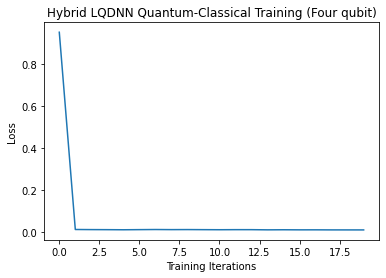

In [20]:
plt.plot(loss_list)
plt.title('Hybrid LQDNN Quantum-Classical Training (Four qubit)')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

In [22]:
print("--- Beginning Test! ---")
lnn_model.eval()
total_lossTestHybridQC = []
correctTestQC = 0
for batch_idx, (data, target) in enumerate(test_dataloader):
    data, target = data.to(device), target.to(device)
    
    dataTest = torch.squeeze(torch.tensor(circ.run(data)))
    targetTest = torch.tensor(circ.run(target))    
    
    with torch.cuda.amp.autocast():
        target_pred = solve_euler_lagrange(lnn_model.forward, dataTest.float())
        correctTestQC += target_pred.eq(targetTest.view_as(target_pred)).sum().item()
        testLoss = loss_fcn(target_pred.unsqueeze(0), targetTest.float())       
    total_lossTestHybridQC.append(testLoss.item())
    
batch_size = 1
print('Performance on test data:\tLoss: {:.4f}\tAccuracy: {:.1f}%'.format(
    sum(total_lossTestHybridQC) / len(total_lossTestHybridQC),
    correctTestQC / len(test_dataloader) * 100 / batch_size)
    )

print('end')

--- Beginning Test! ---


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Performance on test data:	Loss: 0.0085	Accuracy: 0.5%
end
